In [1]:
import os 
import torch
import numpy as np
from torch import nn
from PIL import Image
from glob import glob
from torchvision import models
import torch.nn.functional as F
# Build data loader
from tqdm import tqdm
from torchvision import transforms
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset

In [2]:
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
# Define the base Convolution block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        # Head of block is a convulution layer
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )
        # After conv layer is the batch noarmalization layer 
        self.batch_norm = nn.BatchNorm2d(out_channels)
        
        # Tail of this block is the ReLU function 
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Main forward of this block 
        x = self.conv1(x)
        x = self.batch_norm(x)
        return self.relu(x)

In [4]:
# Define the Spatial Path with 3 layers of ConvBlock 

class SpatialPath(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvBlock(in_channels=3, out_channels=64)
        self.conv2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv3 = ConvBlock(in_channels=128, out_channels=256)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

In [5]:
# spatial_path = SpatialPath()
# spatial_path = spatial_path.cuda()

In [6]:
# from torchsummary import summary

# summary(spatial_path, (3, 256, 256))

In [7]:
# Attention Refinement Module 

class AttentionRefinementModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        
    def forward(self, x_input):
        # Apply Global Average Pooling
        x = self.avg_pool(x_input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        x = self.bn(x)
        x = self.sigmoid(x)
        
        # Channel of x_input and x must be same 
        return torch.mul(x_input, x)

In [8]:
# arm_module = AttentionRefinementModule(in_channels=3, out_channels=3)
# arm_module = arm_module.cuda()

# summary(arm_module, (3, 256, 256))

In [9]:
# Define Feature Fusion Module 
class FeatureFusionModule(nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.conv_block = ConvBlock(in_channels=in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
            
    def forward(self, x_input_1, x_input_2):
        x = torch.cat((x_input_1, x_input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.conv_block(x)
        
        # Apply above branch in feature 
        x = self.avg_pool(feature)
        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        
        # Multipy feature and x 
        x = torch.mul(feature, x)
        
        # Combine feature and x
        return torch.add(feature, x)

In [10]:
# Build context path 
class ContextPath(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet18(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.max_pool = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
    def forward(self, x_input):
        # Get feature from lightweight backbone network
        x = self.conv1(x_input)
        x = self.relu(self.bn1(x))
        x = self.max_pool(x)
        
        # Downsample 1/4
        feature1 = self.layer1(x)
        
        # Downsample 1/8
        feature2 = self.layer2(feature1)
        
        # Downsample 1/16
        feature3 = self.layer3(feature2)
        
        # Downsample 1/32
        feature4 = self.layer4(feature3)
        
        # Build tail with global averange pooling 
        tail = self.avg_pool(feature4)
        return feature3, feature4, tail

In [11]:
# cp = ContextPath()
# cp = cp.cuda()

In [12]:
# Define BiSeNet 

class BiSeNet(nn.Module):
    def __init__(self, num_classes, training=True):
        super().__init__()
        self.training = training
        self.spatial_path = SpatialPath()
        self.context_path = ContextPath()
        self.arm1 = AttentionRefinementModule(in_channels=256, out_channels=256)
        self.arm2 = AttentionRefinementModule(in_channels=512, out_channels=512)
        
        # Supervision for calculate loss 
        self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
        self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)
        
        # Feature fusion module 
        self.ffm = FeatureFusionModule(num_classes=num_classes, in_channels=1024)
        
        # Final convolution 
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        
    def forward(self, x_input):
        # Spatial path output
        sp_out = self.spatial_path(x_input)
        
        # Context path output
        feature1, feature2, tail = self.context_path(x_input)
        
        # apply attention refinement module 
        feature1, feature2 = self.arm1(feature1), self.arm2(feature2)
        
        # Combine output of lightweight model with tail 
        feature2 = torch.mul(feature2, tail)
        
        # Up sampling 
        size2d_out = sp_out.size()[-2:]
        feature1 = F.interpolate(feature1, size=size2d_out, mode='bilinear')
        feature2 = F.interpolate(feature2, size=size2d_out, mode='bilinear')
        context_out = torch.cat((feature1, feature2), dim=1)
        
        # Apply Feature Fusion Module 
        combine_feature = self.ffm(sp_out, context_out)
        
        # Up sampling 
        bisenet_out = F.interpolate(combine_feature, scale_factor=8, mode='bilinear')
        bisenet_out = self.conv(bisenet_out)
        
        # When training model 
        if self.training is True:
            feature1_sup = self.supervision1(feature1)
            feature2_sup = self.supervision2(feature2)
            feature1_sup = F.interpolate(feature1_sup, size=x_input.size()[-2:], mode='bilinear')
            feature2_sup = F.interpolate(feature2_sup, size=x_input.size()[-2:], mode='bilinear')        
            return bisenet_out, feature1_sup, feature2_sup
        return bisenet_out

In [13]:
# bisenet = BiSeNet(num_classes=12, training=True)
# bisenet = bisenet.cuda()

In [14]:
# output, output_sup1, output_sup2 = bisenet(torch.rand((8, 3, 720, 960)).cuda())

# output.shape

In [15]:
# summary(bisenet, (3, 720, 960))

In [16]:
class CamVidDataset(Dataset):
    # Default encoding for pixel value, class name, and class color
    color_encoding = [
        ('sky', (128, 128, 128)),
        ('building', (128, 0, 0)),
        ('pole', (192, 192, 128)),
        ('road', (128, 64, 128)),
        ('side_walk', (0, 0, 192)),
        ('tree', (128, 128, 0)),
        ('sign_symbol', (192, 128, 128)),
        ('fence', (64, 64, 128)),
        ('car', (64, 0, 128)),
        ('pedestrian', (64, 64, 0)),
        ('bicyclist', (0, 128, 192)),
        ('unlabeled', (0, 0, 0))
    ]
    
    def __init__(self, mode='train', num_classes=12):
        self.mode = mode
        self.num_classes = num_classes
        # Normailization 
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        
        self.DATA_PATH = os.path.join(os.getcwd(), 'CamVid/')

        self.train_path, self.val_path, self.test_path = [os.path.join(self.DATA_PATH, x) for x in ['train', 'val', 'test']]
        
        if self.mode == 'train':
            self.data_files = self.get_files(self.train_path)
            self.label_files = [self.get_label_file(f, 'train', 'train_labels') for f in self.data_files]
        elif self.mode == 'val':
            self.data_files = self.get_files(self.val_path)
            self.label_files = [self.get_label_file(f, 'val', 'val_labels') for f in self.data_files]
        elif self.mode == 'test':
            self.data_files = self.get_files(self.test_path)
            self.label_files = [self.get_label_file(f, 'test', 'test_labels') for f in self.data_files]
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")
    
    def get_files(self, data_folder):
        """
            Return all files in folder with extension 
        """
        return glob("{}/*.{}".format(data_folder, 'png'))
    
    def get_label_file(self, data_path, data_dir, label_dir):
        """
            Return label path for data_path file 
        """
        data_path = data_path.replace(data_dir, label_dir)
        fname, ext = data_path.split('.')
        return "{}_L.{}".format(fname, ext)

    def image_loader(self, data_path, label_path):
        data = Image.open(data_path)
        label = Image.open(label_path)

        return data, label
    
    def label_for_cross_entropy(self, label):
        """
            Convert label image to matrix classes for apply cross entropy loss. 
            Return semantic index, label in enumemap of H x W x class
        """
        semantic_map = np.zeros(label.shape[:-1])
        # Fill all value with class 12 - default for all pixels
        semantic_map.fill(self.num_classes - 1)
        # Fill the pixel with correct class 
        for class_index, color_info in enumerate(self.color_encoding):
            color = color_info[1]
            equality = np.equal(label, color)
            class_map = np.all(equality, axis=-1)
            semantic_map[class_map] = class_index
        return semantic_map
            
    
    def __getitem__(self, index):
        """
            Args:
            - index (``int``): index of the item in the dataset
            Returns:
            A tuple of ``PIL.Image`` (image, label) where label is the ground-truth
            of the image.
        """
        
        data_path, label_path = self.data_files[index], self.label_files[index]
        img, label = self.image_loader(data_path, label_path)

        # Apply normalization in img
        img = self.normalize(img)
        # Convert label for cross entropy
        label = np.array(label)
        label = self.label_for_cross_entropy(label)
        label = torch.from_numpy(label).long()
            
        return img, label 
    
    def __len__(self):
        """
            Return len of dataset 
        """
        return len(self.data_files)

In [17]:
camvid = CamVidDataset()

feat, label = camvid.__getitem__(1)
label.shape

torch.Size([720, 960])

In [18]:
# Training 

EPOCHS = 200 
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
CHECKPOINT_STEP = 2
VALIDATE_STEP = 1

NUM_CLASSES = 12

model = BiSeNet(num_classes=NUM_CLASSES, training=True)
model = model.cuda()

# Dataloader for train
dataset_train = CamVidDataset(mode='train')
dataloader_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

# Dataloader for validate
dataset_val = CamVidDataset(mode='val')
dataloader_val = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=True
)

# Optimizer 
optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)

loss_func = torch.nn.CrossEntropyLoss()

In [19]:
from sklearn.metrics import confusion_matrix  
import numpy as np

In [20]:
def reverse_one_hot(image):
    # Convert output of model to predicted class 
    image = image.permute(1, 2, 0)
    x = torch.argmax(image, dim=-1)
    return x

def compute_accuracy(pred, label):
    pred = pred.flatten()
    label = label.flatten()
    total = len(label)
    count = 0.0
    for i in range(total):
        if pred[i] == label[i]:
            count = count + 1.0
    return float(count) / float(total)

def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)


def per_class_iu(hist):
    epsilon = 1e-5
    return (np.diag(hist) + epsilon) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

def val(model, dataloader):
    accuracy_arr = []
    
    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))
    
    with torch.no_grad():
        model.eval()
        print('Starting validate')
        
        for i, (val_data, val_label) in enumerate(dataloader):
            val_data = val_data.cuda()
            # The output of model is (1, num_classes, W, H) => (num_classes, W, H)
            val_output = model(val_data).squeeze()
            # Convert the (num_classes, W, H) => (W, H) with one hot decoder 
            val_output = reverse_one_hot(val_output)
            val_output = np.array(val_output.cpu())
            # Process label. Convert to (W, H) image 
            val_label = val_label.squeeze()
            val_label = np.array(val_label.cpu())
            # Compute accuracy and iou
            accuracy = compute_accuracy(val_output, val_label)
            hist += fast_hist(val_label.flatten(), val_output.flatten(), NUM_CLASSES)
            # Append for calculate 
            accuracy_arr.append(accuracy)
        miou_list = per_class_iu(hist)[:-1]
        mean_accuracy, mean_iou = np.mean(accuracy_arr), np.mean(miou_list)
        print('Mean accuracy: {} Mean IoU: {}'.format(mean_accuracy, mean_iou))
        return mean_accuracy, mean_iou

In [21]:
model.load_state_dict(torch.load('checkpoints/best_model.pth'))

<All keys matched successfully>

In [22]:
# # Loop for training 
# torch.cuda.empty_cache()

# max_miou = 0

# for epoch in range(EPOCHS):
#     model.train()
#     tq = tqdm(total=len(dataloader_train) * BATCH_SIZE)
#     tq.set_description('Epoch {}/{}'.format(epoch, EPOCHS))

#     loss_record = []
    
#     for i, (data, label) in enumerate(dataloader_train):
#         data = data.cuda()
#         label = label.cuda()
#         output, output_sup1, output_sup2 = model(data)
#         loss1 = loss_func(output, label)
#         loss2 = loss_func(output_sup1, label)
#         loss3 = loss_func(output_sup2, label)

#         # Combine 3 loss   
#         loss = loss1 + loss2 + loss3
#         tq.update(BATCH_SIZE)
#         tq.set_postfix(loss='%.6f' % loss)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         loss_record.append(loss.item())
#     tq.close()
#     loss_train_mean = np.mean(loss_record)
#     print('loss for train : %f' % (loss_train_mean))

#     # Save checkpoint 
#     if epoch % CHECKPOINT_STEP == 0:
#         torch.save(model.state_dict(), 'checkpoints/lastest_model.pth')
        
#     # Validate save best model 
#     # Save checkpoint 
#     if epoch % VALIDATE_STEP == 0:
#         _, mean_iou = val(model, dataloader_val)
#         if mean_iou > max_miou:
#             max_miou = mean_iou
#             print('Save best model with mIoU = {}'.format(mean_iou))
#             torch.save(model.state_dict(), 'checkpoints/best_model.pth')

In [23]:
# Dataloader for testing
dataset_test = CamVidDataset(mode='test')
dataloader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=True
)

val(model, dataloader_test)

Starting validate


/home/vibloteam/timit_env/lib/python3.5/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Mean accuracy: 0.8569447052336671 Mean IoU: 0.5705247647870512


(0.8569447052336671, 0.5705247647870512)

In [24]:
def colour_code_segmentation(image, label_values):
    w = image.shape[0]
    h = image.shape[1]
    x = np.zeros([w,h,3], dtype=np.uint8)
    colour_codes = label_values
    
    for i in range(0, w):
        for j in range(0, h):
            x[i, j, :] = colour_codes[int(image[i, j])]
    return x

In [32]:
from matplotlib import pyplot as plt

In [34]:
def get_label_values(dataset):
    # Input is dataset instance define above 
    return [v[1] for v in dataset_test.color_encoding]

In [62]:
def img_show(img):
    fig = plt.figure()
    plt.imshow(img, interpolation='nearest')
    plt.show()
    
def to_rgb(image):
    test_label_vis = colour_code_segmentation(test_label, label_values)
    img = Image.fromarray(test_label_vis, 'RGB')
    return img

In [60]:
def test_single_image(model, dataset_test, index):
    test_image, test_label = dataset_test.__getitem__(index)
    test_image, test_label = test_image.cuda(), test_label.cuda()
    
    model.eval()

    test_output = model(test_image.unsqueeze(0))
    # Convert the (num_classes, W, H) => (W, H) with one hot decoder 
    test_output = reverse_one_hot(test_output.squeeze(0))
    test_output = np.array(test_output.cpu())
    # Process label. Convert to (W, H) image 
    test_label = test_label.squeeze()
    test_label = np.array(test_label.cpu())
    return test_label, test_output

/home/vibloteam/timit_env/lib/python3.5/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


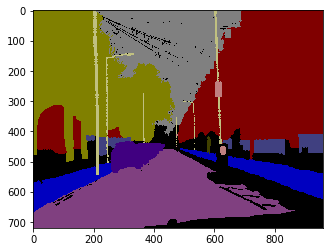

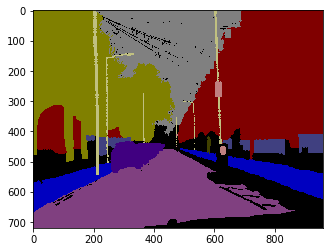

In [66]:
test_label, test_output = test_single_image(model, dataset_test, 50)

img_show(to_rgb(test_label))

img_show(to_rgb(test_output))